# Parametric Gain and Quantum Adiabatic Frequency Conversion

Here we simulate the parametric gain of long degenerate optical parametric amplifiers (DOPA), and:
- show the covariance matrices and photon correlations,
- show how the output scales as a function of driving energy,
- perform decomposition to see the amplification supermodes.

In addition we show how adiabatic frequency conversion can be used to convert these modes.

These are some of the experiments and simulations from *Highly multimode programmable squeezed light at visible wavelengths through broadband upconversion* 

In [1]:
cd ../../src/NonlinearOptics/

/home/fpresutti/src/NonlinearOptics


In [2]:
import numpy as np
from numpy.fft import fft, ifft, fftshift, ifftshift

from nonlinearmedium import Chi2PDC, Chi2SFG

from materials import MgOLNe, KTPz

from poling import *
from classical import *
from multimode import *
from decompositions import bloch_messiah

In [3]:
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter1d

In [4]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LogNorm

%matplotlib notebook
plt.rcParams["figure.figsize"] = [9, 6]

# Timescale and Wavelengths

In [5]:
c = 299792458 # m / s

# Bandwidth limited pulse time scale
timeScale = 200e-3 # ps
timeScale /= 2 * np.log(1 + np.sqrt(2))

signalWav = 1550 # nm
pumpWav   = signalWav / 2 # nm

pumpFreq   = 2e-3 * np.pi * c / pumpWav   # 2pi THz
signalFreq = 2e-3 * np.pi * c / signalWav # 2pi THz

# DOPA Crystal Parameters
Dispersion, geometry and energy

In [6]:
temperature = 57.3 # C

# Nonlinear Coefficient
dopaMaterial = MgOLNe
d = 22 # pm / V

# Group Velocity Dispersion -- ps^2 / km
beta2s = 1e27 * dopaMaterial.gvd(signalWav*1e-3, temperature)
beta2p = 1e27 * dopaMaterial.gvd(pumpWav*1e-3,   temperature)

# Relative Group Velocity
ngs = dopaMaterial.ng(signalWav*1e-3, temperature)
ngp = dopaMaterial.ng(pumpWav*1e-3,   temperature)

# Index of refraction
indexS = dopaMaterial.n(signalWav*1e-3, temperature)
indexP = dopaMaterial.n(pumpWav*1e-3,   temperature)

# TOD -- ps^3 / km
beta3s = 1e39 * dopaMaterial.beta3(signalWav*1e-3, temperature)
beta3p = 1e39 * dopaMaterial.beta3(pumpWav*1e-3,   temperature)

In [7]:
# Walk-off
beta1p, beta1s = findFrameOfReference(ngp, ngs) # ps / km

# Phase velocity mismatch
diffBeta0pdc = 2 * np.pi * (indexP / pumpWav - 2 * indexS / signalWav) * 1e12 # km^-1

In [8]:
# Intensity, timescale and length
energy1    = 155e-12 # J
peakPower1 = energy1 / (timeScale * 1e-12) # W
length1    = 4.0e-2 # m
pulseRad   = 6.0e-6 # m

print("beam waist = {:0.0f} um".format(pulseRad * 1e6))

beam waist = 6 um


In [9]:
# Characteristic lengths
DS1 = calculateDispLength(beta2p, timeScale, pulseTypeFWHM=None) # m
NL1 = calculateChi2NlLength(d, peakPower1, pulseRad, indexP, indexS, signalFreq) # m

# Normalized quantities
diffBeta0pdcN, (beta1pN, beta1sN), beta2sN, (beta3pN, beta3sN) = \
  normalizeDispersion(timeScale, DS1 / 1000, diffBeta0pdc, (beta1p, beta1s), beta2s, (beta3p, beta3s))

relLength = length1 / DS1
relNlLength = NL1 / DS1

pdcParams = {"relativeLength": relLength,
             "beta2":  np.sign(beta2p),
             "beta2s": beta2sN,
             "beta3":  beta3pN,
             "beta3s": beta3sN,
             "beta1":  beta1pN,
             "beta1s": beta1sN,
             "diffBeta0": diffBeta0pdcN,
             "nlLength": relNlLength,
             }

# Axes

In [10]:
# nt works best as multiples of 2, 3 and 5
nt = 3**2 * 2**9
tMax = 225

# normalized
tau   = (2 * tMax / nt) * ifftshift(np.arange(-nt / 2, nt / 2))
omega = (-np.pi / tMax) *  fftshift(np.arange(-nt / 2, nt / 2))

wMax = np.max(omega)
angFreqMax = wMax / timeScale
freqMax = angFreqMax / (2 * np.pi)

# dimensionful
time    = tau * timeScale   # ps
angFreq = omega / timeScale # 2 pi THz
wavelengthP = 2e-3 * np.pi * c / (angFreq + pumpFreq) # nm
wavelengthS = 2e-3 * np.pi * c / (angFreq + signalFreq) # nm

# Poling

In [11]:
squeezePoling = periodicPoling(pdcParams["diffBeta0"], pdcParams["relativeLength"])

print("# Domains: {:d}".format(squeezePoling.size))
print("Domain Length: {:.02f} um (Period: {:.02f})".format(squeezePoling[0] * 1e6 * DS1,
                                                           squeezePoling[0] * 2e6 * DS1))

# Domains: 4149
Domain Length: 9.64 um (Period: 19.28)


# Instantiate solver

We can explicitly and exactly simulate with poling, or in a rotating frame with an effective nonlinearity, which will be faster.

In [12]:
params1 = {**pdcParams,
           "tPrecision": nt, "tMax": tMax,
           "pulseType": 1,

           # For explicit poling:
           #"zPrecision": int(5 * squeezePoling.size
           #                  * min(1, pdcParams["nlLength"]) / pdcParams["relativeLength"]),
           #"poling": squeezePoling,

           # Poling rotating frame:
           "zPrecision": 200,
           "nlLength": pdcParams["nlLength"] * np.pi / 2,
           "diffBeta0": 0,
          }

In [13]:
crystal = Chi2PDC(**params1)

Check the pump propagation in the simulation

In [14]:
crystal.runPumpSimulation()

<IPython.core.display.Javascript object>


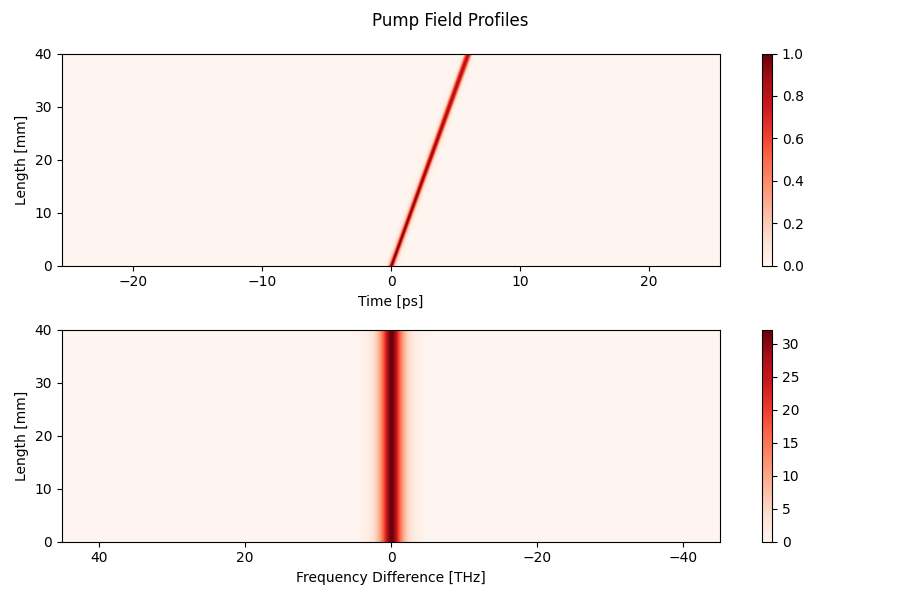

In [15]:
fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)
plt.imshow(np.abs(fftshift(crystal.pumpTime[::100], axes=1)), cmap="Reds", aspect="auto", origin="lower",
           extent=[-tMax * timeScale, tMax * timeScale, 0, 1000 * length1])
plt.colorbar()
plt.xlabel("Time [ps]")
plt.ylabel("Length [mm]")

ax = fig.add_subplot(2, 1, 2)
plt.imshow(np.abs(fftshift(crystal.pumpFreq[::100], axes=1)), cmap="Reds", aspect="auto", origin="lower",
           extent=[freqMax, -freqMax, 0, 1000 * length1])
plt.colorbar()
plt.xlabel("Frequency Difference [THz]")
plt.ylabel("Length [mm]")

plt.suptitle("Pump Field Profiles")
plt.tight_layout();

# Supermodes and Squeezing

Drive the DOPA with different pump energies and compare the output.
For each driving energy we compute the Green's functions $C$ and $S$ and compare the parametric gain spectrum, and the supermodes and squeezing.

In [16]:
pumpProfTemp = 1 / np.cosh(tau)
pumpProfFreq = fft(pumpProfTemp)

In [17]:
energies = np.linspace(0.02, 1, 10)

In [18]:
toXPTrans, frXPTrans = basisTransforms(nt)

In [19]:
Cs, Ss = [None] * len(energies), [None] * len(energies)

In [20]:
for i, relativeEnergy in enumerate(energies):
  crystal.setPump(pumpProfTemp * np.sqrt(relativeEnergy))
  Cs[i], Ss[i] = crystal.computeGreensFunction(nThreads=40, runPump=True)

In [21]:
Zs = [calcQuadratureGreens(C, S) for C, S in zip(Cs, Ss) if C is not None and S is not None]

aCovMats = [calcCovarianceMtxABasis(C, S) for C, S in zip(Cs, Ss) if C is not None and S is not None]
covMats = [calcCovarianceMtx(Z, tol=5e-2) for Z in Zs]

photonCovMatrix = (np.abs(aCovMats[-1][:nt, :nt]).real**2
                 + np.abs(aCovMats[-1][:nt, nt:]).real**2 - 0.25 * np.eye(nt))

In [22]:
# Perform decomposition on only the first and last simulations to save time:
decomps = [bloch_messiah(Zs[0], tol=5e-4), bloch_messiah(Zs[-1], tol=5e-4)]
# decomps = [bloch_messiah(Z, tol=5e-4) for Z in Zs]

abases = [(frXPTrans @ decomp[0] @ toXPTrans)[:nt, :nt].T for decomp in decomps]
diags = [decomp[1].diagonal() for decomp in decomps]

In [23]:
last = 1000

Photon Covariance Matrix:
$C(n_i, n_j) = \langle n_i, n_j \rangle - \langle n_i \rangle \langle n_j \rangle$

and the Field covariance matrix:
$\sigma_{ij} = \langle \hat \xi, \hat \xi^\dagger \rangle - \langle \hat \xi \rangle \langle \hat \xi^\dagger \rangle, ~ \hat \xi^\intercal = (\hat a_1, \ldots, \hat a_M, \hat a_1^\dagger, \ldots, \hat a_M^\dagger)$

<IPython.core.display.Javascript object>


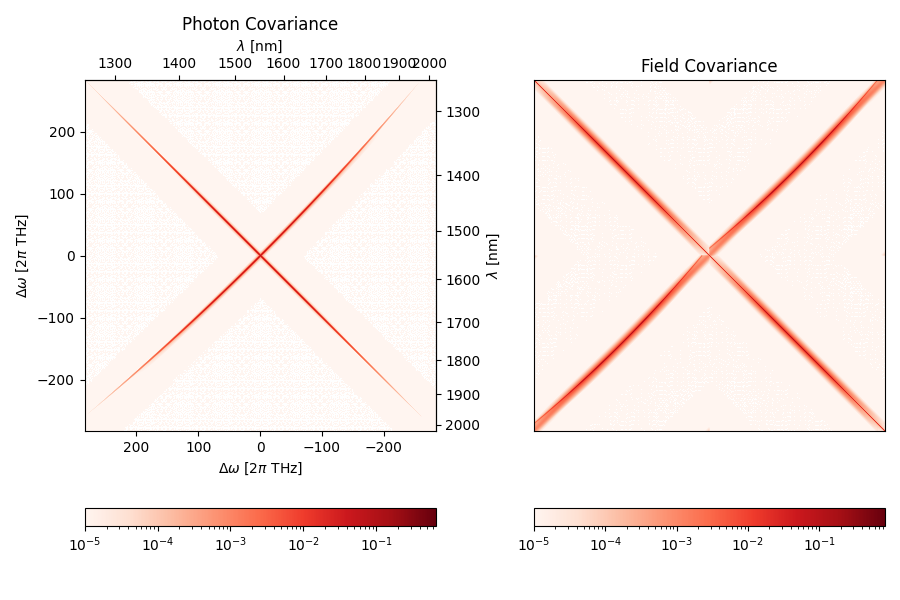

/usr/local/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':


In [24]:
fig = plt.figure()
plt.subplot(1, 2, 1)

plt.imshow(photonCovMatrix, "Reds", extent=[angFreqMax, -angFreqMax, -angFreqMax, angFreqMax],
           norm=LogNorm(vmin=1e-5, vmax=photonCovMatrix.max()))

plt.title("Photon Covariance")
plt.xlabel("$\Delta \omega$ [$2 \pi$ THz]")
plt.ylabel("$\Delta \omega$ [$2 \pi$ THz]")

fwd, bck = lambda x: 2e-3 * np.pi * c / (x + signalFreq),\
           lambda x: 2e-3 * np.pi * c / x - signalFreq

ax = plt.gca()
secax = ax.secondary_xaxis("top", functions=(fwd, bck))
secax.set_xlabel("$\lambda$ [nm]")
secax = ax.secondary_yaxis("right", functions=(fwd, bck))
secax.set_ylabel("$\lambda$ [nm]");
plt.colorbar(orientation="horizontal")

plt.subplot(1, 2, 2)

plt.imshow(np.abs(aCovMats[-1]), "Reds",
           norm=LogNorm(vmin=1e-5, vmax=np.abs(aCovMats[-1]).max()))
plt.title("Field Covariance");
plt.xticks([])
plt.yticks([])
plt.colorbar(orientation="horizontal")

plt.tight_layout()

The supermodes, in time and frequency (Fourier transforms of each other), and their corresponding squeezing antisqueezing levels (supermodes come in pairs)

<IPython.core.display.Javascript object>


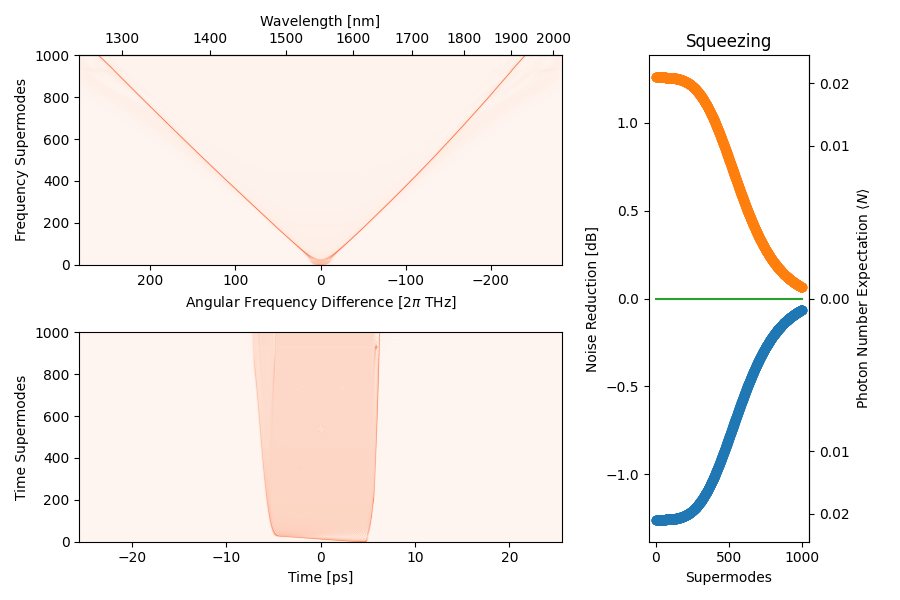

/usr/local/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]


<IPython.core.display.Javascript object>


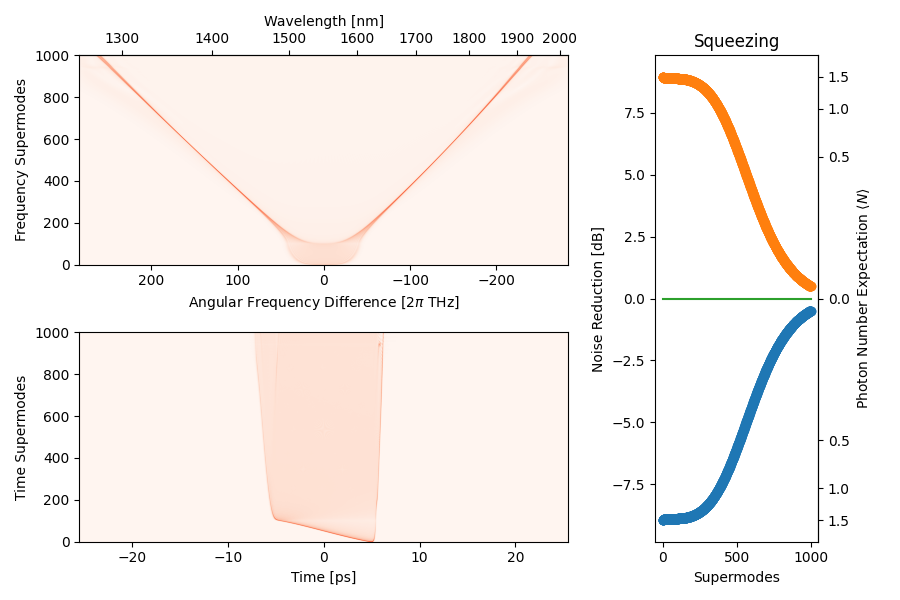

In [25]:
for abasis, diag in zip(abases, diags):
  fig = plt.figure()
  gs = gridspec.GridSpec(nrows=2, ncols=2, width_ratios=[3, 1])

  ax = fig.add_subplot(gs[0, 0])
  plt.imshow(np.abs(abasis[:last]),
             origin="lower", cmap="Reds", aspect="auto",
             extent=[angFreqMax, -angFreqMax, 0, last])
  plt.ylabel("Frequency Supermodes")
  plt.xlabel("Angular Frequency Difference [$2 \pi$ THz]")

  fwd, bck = lambda x: 2e-3 * np.pi * c / (x + signalFreq),\
             lambda x: 2e-3 * np.pi * c / x - signalFreq
  secax = ax.secondary_xaxis("top", functions=(fwd, bck))
  secax.set_xlabel("Wavelength [nm]")

  ax = fig.add_subplot(gs[1, 0])
  plt.imshow(np.abs(fftshift(ifft(fftshift(abasis[:last]), axis=1))),
             origin="lower", cmap="Reds", aspect="auto",
             extent=[-tMax * timeScale, tMax * timeScale, 0, last])
  plt.ylabel("Time Supermodes")
  plt.xlabel("Time [ps]")

  ax = fig.add_subplot(gs[:, 1])
  plt.plot(20 * np.log10(diag[nt:nt+last]), "-o")
  plt.plot(20 * np.log10(diag[:last]), "-o")
  plt.plot(20 * np.log10(diag[nt:nt+last] * diag[:last]))
  plt.title("Squeezing")
  plt.ylabel("Noise Reduction [dB]")
  plt.xlabel("Supermodes")

  fwd, bck = lambda x: np.sinh(np.log(10**(np.abs(x) / 20)))**2 * np.sign(x), \
             lambda x: -20 * np.log10(np.exp(np.arcsinh(np.sqrt(np.abs(x))))) * np.sign(x)
  secax = ax.secondary_yaxis("right", functions=(fwd, bck))
  secax.set_ylabel(r"Photon Number Expectation $\langle N \rangle$")

  plt.tight_layout()
  secax.set_yticks(secax.get_yticks())
  secax.set_yticklabels([label.get_text().lstrip("−") for label in secax.get_yticklabels()])

# Parametric gain spectrum and curve

### InGaAs SPAD QE

In [26]:
ingaasWavs = np.array([902.9, 910.7, 920.0, 928.7, 937.5, 946.1, 954.9, 963.6, 972.3, 981.1, 989.8, 998.5,
                       1007.2, 1015.9, 1024.7, 1033.4, 1042.1, 1050.8, 1059.6, 1068.3, 1077.0, 1085.7, 1094.4,
                       1103.2, 1111.9, 1120.7, 1127.4, 1133.3, 1138.4, 1144.4, 1151.1, 1158.3, 1166.6, 1175.3,
                       1184.0, 1192.7, 1201.5, 1210.2, 1218.9, 1227.6, 1236.4, 1245.1, 1253.8, 1262.5, 1271.2,
                       1280.0, 1288.7, 1297.4, 1306.1, 1314.8, 1323.6, 1332.3, 1341.0, 1349.7, 1358.4, 1367.2,
                       1375.9, 1384.6, 1393.3, 1402.1, 1410.8, 1419.5, 1428.2, 1436.9, 1445.7, 1454.4, 1463.1,
                       1471.8, 1480.5, 1489.3, 1498.0, 1506.7, 1515.4, 1524.1, 1532.9, 1541.6, 1550.3, 1559.0,
                       1567.8, 1576.5, 1582.4, 1587.2, 1592.2, 1599.2, 1602.7, 1607.0, 1611.0, 1615.2, 1618.9,
                       1623.2, 1627.6, 1631.9, 1636.3, 1640.3, 1647.8, 1655.8, 1661.5, 1670.0, 1678.7, 1687.5,
                       1696.2])
ingaasEffs = np.array([0.199, 0.364, 0.519, 0.66, 0.803, 0.896, 0.945, 1.033, 1.131,1.239, 1.334, 1.419, 1.53,
                       1.63, 1.792, 1.976, 2.144, 2.32, 2.486, 2.653, 2.832, 3.036, 3.259, 3.55, 3.904, 4.263,
                       4.806, 5.361, 5.836, 6.358, 6.854, 7.351, 7.835, 8.3, 8.658, 8.893, 9.145, 9.448, 9.755,
                       10.076, 10.416, 10.735, 11.032, 11.332, 11.635, 11.903, 12.075, 12.227, 12.319, 12.364,
                       12.391, 12.374, 12.352, 12.323, 12.266, 12.106, 11.934, 11.832, 11.74, 11.66, 11.549,
                       11.455, 11.38, 11.312, 11.263, 11.232, 11.148, 11.071, 11.005, 11.003, 11.017, 10.948,
                       10.87, 10.751, 10.586, 10.418, 10.209, 10.002, 9.734, 9.427, 8.855, 8.242, 7.745, 7.224,
                       6.757, 6.218, 5.701, 5.146, 4.63, 4.082, 3.54, 2.997, 2.461, 1.939, 1.389, 0.816, 0.477,
                       0.321, 0.151, 0.079, 0.048])

interpsEffs = interp1d(ingaasWavs, ingaasEffs * 1.5 * 0.01, "cubic", bounds_error=False, fill_value=0)

QE = interpsEffs(fftshift(wavelengthS))

### InGaAs Power Meter Responsivity

In [27]:
powerMeterWavs, PMReponsiv = np.loadtxt("../../sims/GBSJupyterNotebooks/S154C_Responsivity.csv",
                                        delimiter=",", skiprows=1).T

interpResp = interp1d(powerMeterWavs, PMReponsiv / powerMeterWavs, "cubic", bounds_error=False, fill_value=0)

RespPm = interpResp(fftshift(wavelengthS))

# Gain spectrum

Of the DOPA as a function of pump energy:

<IPython.core.display.Javascript object>


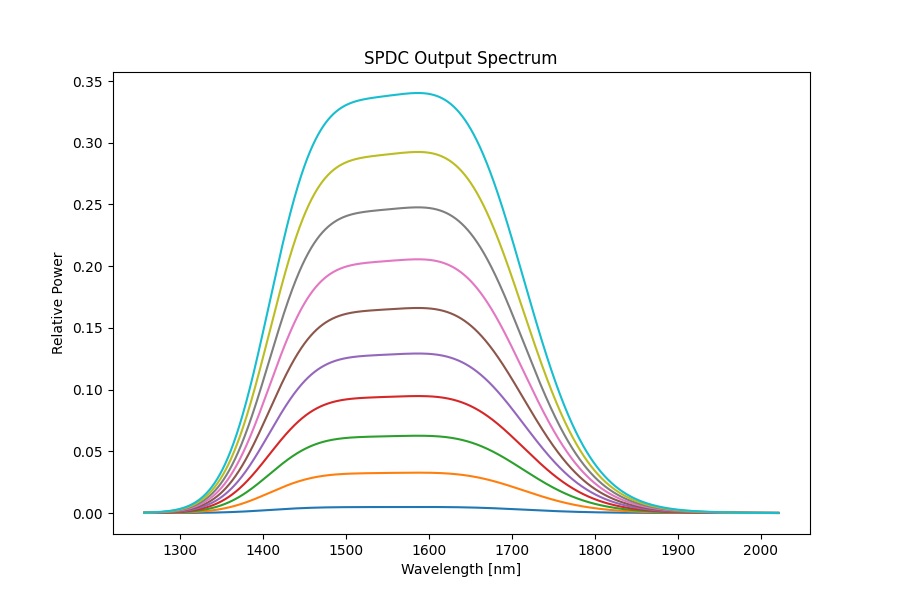

In [28]:
fig = plt.figure()

for covMtx in aCovMats:
  plt.plot(fftshift(wavelengthS), photonMeanA(covMtx))

plt.title("SPDC Output Spectrum")
plt.xlabel("Wavelength [nm]")
plt.ylabel("Relative Power");

Multiplied by QE:

<IPython.core.display.Javascript object>


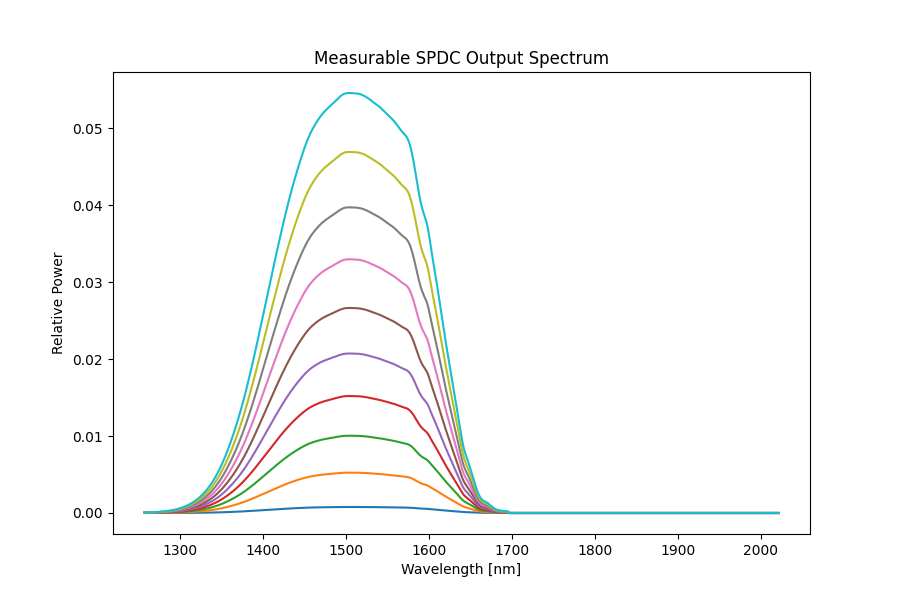

In [29]:
fig = plt.figure()

for covMtx in aCovMats:
  plt.plot(fftshift(wavelengthS), QE * photonMeanA(covMtx))

plt.title("Measurable SPDC Output Spectrum")
plt.xlabel("Wavelength [nm]")
plt.ylabel("Relative Power");

# Parametric Gain
Number of downconverted photons as a function of pump power:

In [30]:
inputEnergies = energies * energy1 * 1e9 # nJ
photonSpectra = np.array([photonMeanA(covMtx) for covMtx in aCovMats])
nPhotonsIdeal = np.sum(photonSpectra, axis=1)
nPhotonsDetect = np.sum(photonSpectra * RespPm / interpResp(1550), axis=1)

<IPython.core.display.Javascript object>


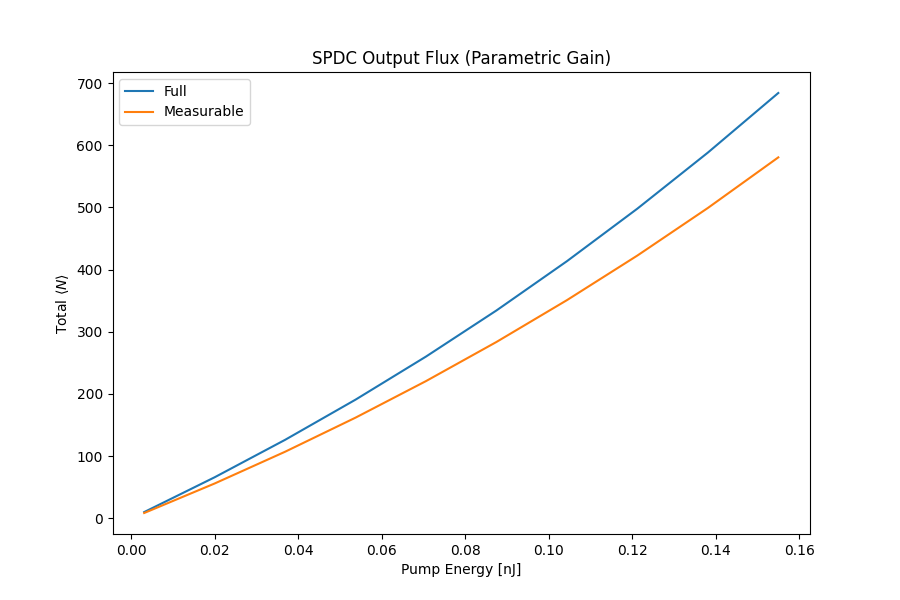

In [31]:
fig = plt.figure()

plt.plot(inputEnergies, nPhotonsIdeal, label="Full")
plt.plot(inputEnergies, nPhotonsDetect, label="Measurable")

plt.title("SPDC Output Flux (Parametric Gain)")
plt.xlabel("Pump Energy [nJ]")
plt.ylabel(r"Total $\langle N \rangle$")
plt.legend();

How much signal is lost due to the QE

<IPython.core.display.Javascript object>


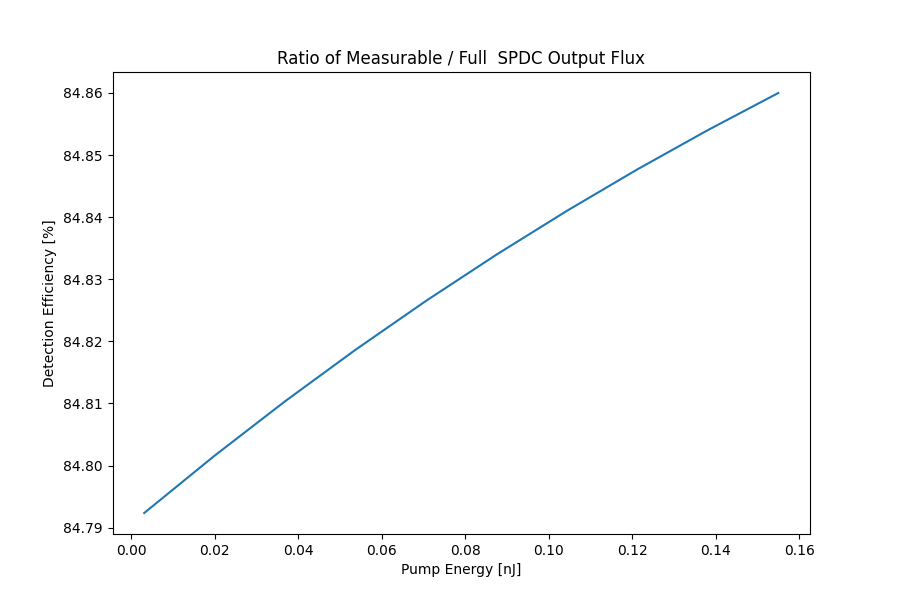

In [32]:
fig = plt.figure()

plt.plot(inputEnergies, 100 * nPhotonsDetect / nPhotonsIdeal)

plt.title("Ratio of Measurable / Full  SPDC Output Flux")
plt.xlabel("Pump Energy [nJ]")
plt.ylabel("Detection Efficiency [%]");

Expected detector response with an 80 MHz repetition rate:

In [33]:
simulatedMeasurements = \
         np.sum(photonSpectra * 1550 / wavelengthS * RespPm / interpResp(1550), axis=1)\
         * 1e9 * (80e6) * (1.98644582e-25 / 1.55e-6)

Perform a fit to the expected power measurement by converting from power to expected photon number.

In [34]:
powerToNumber = lambda x: (x * 1e-9) / (80e6) / (1.98644582e-25 / 1.55e-6)
NumberToPower = lambda x: (x *  1e9) * (80e6) * (1.98644582e-25 / 1.55e-6)

def nPhotons(p, M, p0):
  return M * np.sinh(np.sqrt(p / p0))**2

popt, pcov = curve_fit(nPhotons, energies, powerToNumber(simulatedMeasurements),
                       p0=[500, 1])

print("eta M = {:.1f}\nP_0 = {:.3f}".format(*popt))

eta M = 384.4
P_0 = 0.953


<IPython.core.display.Javascript object>


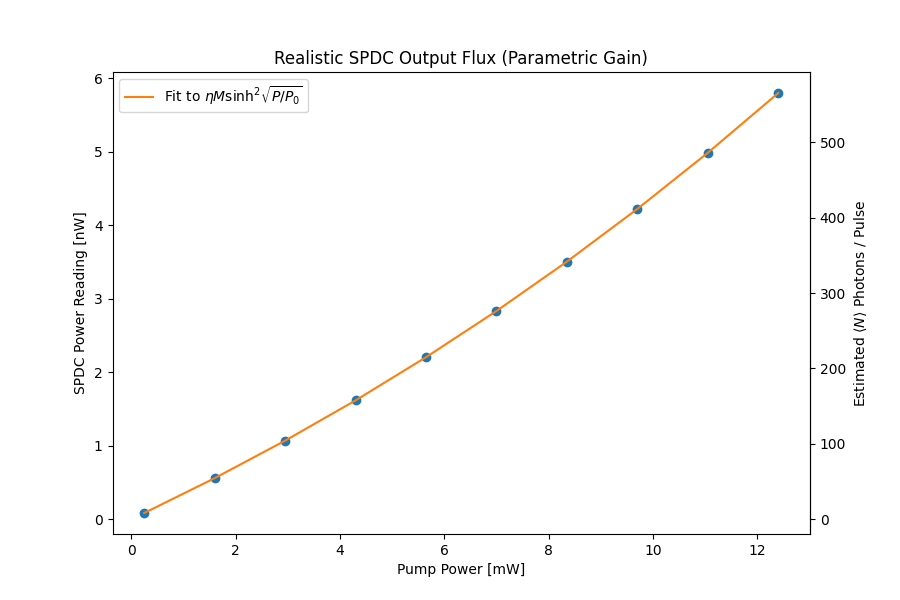

In [35]:
plt.figure()

plt.plot(inputEnergies * 1e-6 * 80e6, simulatedMeasurements, "o")
plt.plot(inputEnergies * 1e-6 * 80e6, NumberToPower(nPhotons(energies, *popt)),
         label=r"Fit to $\eta M \sinh^2 \sqrt{P/P_0}$")

plt.legend()

secax = plt.gca().secondary_yaxis("right", functions=(powerToNumber, NumberToPower))
secax.set_ylabel(r"Estimated $\langle N \rangle$ Photons / Pulse");

plt.title("Realistic SPDC Output Flux (Parametric Gain)")
plt.xlabel("Pump Power [mW]")
plt.ylabel(r"SPDC Power Reading [nW]");

# Conversion Process
### Wavelengths

In [36]:
afcWav   = 1033 # nm
finalWav = 1 / (1/signalWav + 1/afcWav)  # nm
shgWav   = afcWav / 2 # nm

afcFreq    = 2e-3 * np.pi * c / afcWav   # 2pi THz
finalFreq  = 2e-3 * np.pi * c / finalWav # 2pi THz
shgFreq    = 2e-3 * np.pi * c / shgWav   # 2pi THz

wavelengthF = 2e-3 * np.pi * c / (angFreq + finalFreq) # nm
wavelengthA = 2e-3 * np.pi * c / (angFreq + afcFreq)   # nm

### AFC Crystal Parameters
Neglect $\chi^{(3)}$ effects

In [37]:
temperature = 48 # C

afcMaterial = KTPz
d = 15.5 # pm / V

# Group Velocity Dispersion -- ps^2 / km
beta2f = 1e27 * afcMaterial.gvd(finalWav*1e-3, temperature)
beta2a = 1e27 * afcMaterial.gvd(afcWav*1e-3,   temperature)
beta2b = 1e27 * afcMaterial.gvd(shgWav*1e-3,   temperature)
beta2s = 1e27 * afcMaterial.gvd(signalWav*1e-3, temperature)

# Relative Group Velocity
ngf = afcMaterial.ng(finalWav*1e-3,  temperature)
nga = afcMaterial.ng(afcWav*1e-3  ,  temperature)
ngb = afcMaterial.ng(shgWav*1e-3,    temperature)
ngs = afcMaterial.ng(signalWav*1e-3, temperature)

# Index of refraction
indexF = afcMaterial.n(finalWav*1e-3,  temperature)
indexA = afcMaterial.n(afcWav*1e-3,    temperature)
indexB = afcMaterial.n(shgWav*1e-3,    temperature)
indexS = afcMaterial.n(signalWav*1e-3, temperature)

# TOD -- ps^3 / km
beta3f = 1e39 * afcMaterial.beta3(finalWav*1e-3, temperature)
beta3a = 1e39 * afcMaterial.beta3(afcWav*1e-3,   temperature)
beta3b = 1e39 * afcMaterial.beta3(shgWav*1e-3,   temperature)
beta3s = 1e39 * afcMaterial.beta3(signalWav*1e-3, temperature)

# Intensity, timescale and length
energy2    = 5000e-9 # J
peakPower2 = energy2 / (timeScale * 1e-12) # W
length2    = 3.0e-2 # m
pulseRad   = 1.5e-4 # m

print("beam waist = {:0.0f} um".format(pulseRad * 1e6))

# Walk-off
beta1fSFG, beta1pSFG, beta1sSFG = findFrameOfReference(ngf, nga, ngs) # ps / km
beta1pSHG, beta1b = findFrameOfReference(nga, ngb) # ps / km

# Phase velocity mismatch
diffBeta0sfg = 2 * np.pi * (indexA / afcWav + indexS / signalWav - indexF / finalWav) * 1e12 # km^-1
diffBeta0shg = 2 * np.pi * (indexB / shgWav - 2 * indexA / afcWav) * 1e12 # km^-1

beam waist = 150 um


In [38]:
# Characteristic lengths
DS2 = calculateDispLength(beta2a, timeScale, pulseTypeFWHM=None)
NLo = calculateChi2NlLength(d, peakPower2, pulseRad, indexA, indexS, signalFreq, gaussianBeam=True)
NLf = calculateChi2NlLength(d, peakPower2, pulseRad, indexA, indexF, finalFreq, gaussianBeam=True)

# Normalized quantities
relLength = length2 / DS2
relNlLength = NLf / DS2
relNlLength2 = NLo / DS2

rayleighLengthN = calcRayleighLength(pulseRad, afcWav * 1e-9, indexA) / DS2 # bigger beam width than signal

diffBeta0sfgN,\
(beta1sNSFG, beta1pNSFG, beta1fNSFG),\
(beta2fN, beta2sN),\
(beta3fN, beta3aN, beta3sN) = \
  normalizeDispersion(timeScale, DS2 / 1000,
                      diffBeta0sfg, (beta1sSFG, beta1pSFG, beta1fSFG),
                      (beta2f, beta2s), (beta3f, beta3a, beta3s))

afcParams = {"relativeLength": relLength,
             "beta2":  np.sign(beta2a),
             "beta2s": beta2fN,
             "beta2o": beta2sN,
             "beta3":  beta3aN,
             "beta3s": beta3fN,
             "beta3o": beta3sN,
             "beta1":  beta1pNSFG,
             "beta1s": beta1fNSFG,
             "beta1o": beta1sNSFG,
             "diffBeta0":  diffBeta0sfgN,
             "nlLength": relNlLength,
             "nlLengthOrig": relNlLength2,
             "rayleighLength": rayleighLengthN,
             }

amplitudeRatio = NLo / NLf

### Crystal Poling

In [39]:
mindk, maxdk = threeWaveMismatchRange(omega, 12, afcParams["diffBeta0"], +1, -1,
                                      *map(afcParams.get, ("beta1",  "beta2",  "beta3")),
                                      *map(afcParams.get, ("beta1o", "beta2o", "beta3o")),
                                      *map(afcParams.get, ("beta1s", "beta2s", "beta3s")))

tolerance = 2.5e-8 / DS2 # Assume domain sizes must be multiples of 0.025 um
detuneFrac = afcParams["relativeLength"] * 0.025 / 3

convertPoling = linearPoling(mindk, maxdk, afcParams["relativeLength"] - 2 * detuneFrac, tolerance)

print("Main domain size range {:.2f} - {:.2f} um".format(convertPoling[0]  * DS2 * 1e6,
                                                         convertPoling[-2] * DS2 * 1e6))

ka = 0.05 * (mindk + maxdk) / 2

polingIn  = detunePoling(mindk * 0.85, mindk, mindk, ka, detuneFrac, tolerance)
polingOut = detunePoling(maxdk, 1.15 * maxdk, maxdk, ka, detuneFrac + polingIn[-1] + convertPoling[-1], tolerance)

convertPoling = np.concatenate([polingIn[:-1], convertPoling[:-1], polingOut])

print("Full domain size range {:.2f} - {:.2f} um".format(convertPoling[0]  * DS2 * 1e6,
                                                         convertPoling[-2] * DS2 * 1e6))

Main domain size range 8.47 - 6.35 um
Full domain size range 9.67 - 5.83 um


<IPython.core.display.Javascript object>


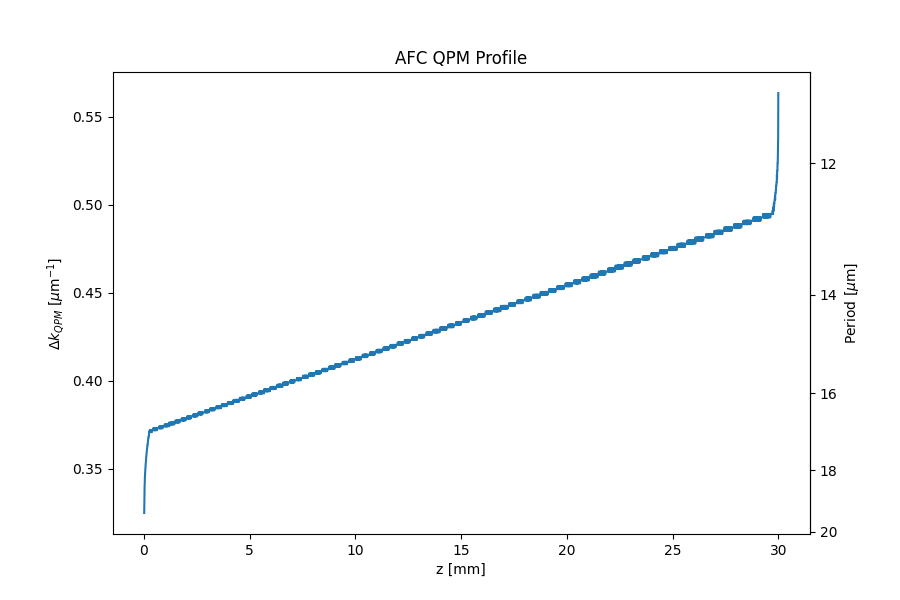

In [40]:
fig = plt.figure()
plt.plot(np.cumsum(convertPoling) * DS2 * 1e3, np.pi / (convertPoling * DS2 * 1e6), "-")
\
fwd, bck = lambda x: 2 * np.pi / x,\
           lambda x: 2 * np.pi / x
secax = plt.gca().secondary_yaxis("right", functions=(fwd, bck))
secax.set_ylabel("Period [$\mu$m]")

plt.title("AFC QPM Profile")
plt.ylabel("$\Delta k_{QPM}$ [$\mu$m$^{-1}$]")
plt.xlabel("z [mm]");

### Pulse Profile

In [41]:
pumpProfTempAFC = 1 / np.cosh(tau)
pumpProfFreqAFC = fft(pumpProfTemp)

delay = 0.5 * (afcParams["beta1"] - afcParams["beta1o"]) * afcParams["relativeLength"]
bckgndPhase = np.exp(-1j * delay * omega + 0.5j * 75 * omega**2)

afcPump = ifft(pumpProfFreqAFC * bckgndPhase)

afcPowerNorm = 1 / np.max(np.abs(afcPump))
afcPump *= afcPowerNorm

<IPython.core.display.Javascript object>


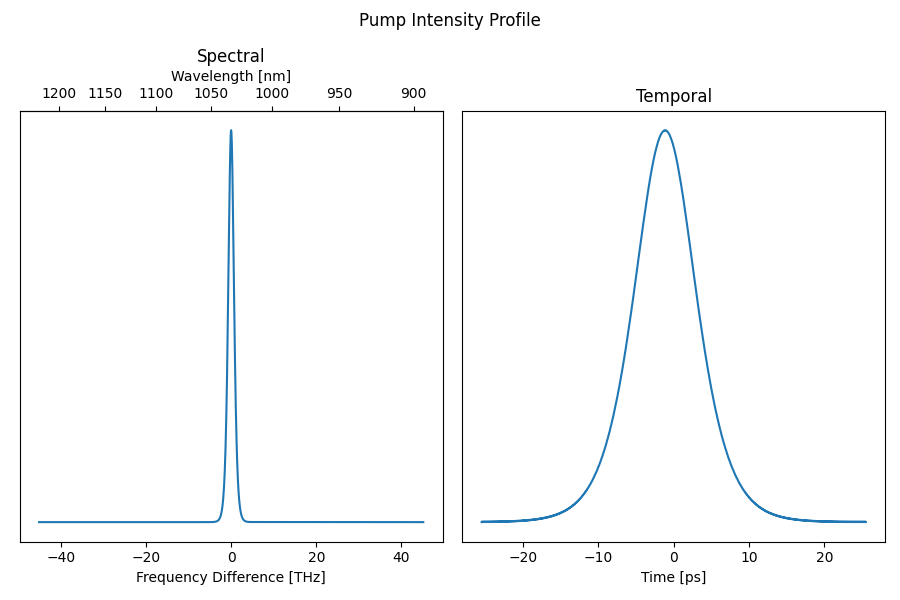

/usr/local/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


In [42]:
fig = plt.figure()

ax = fig.add_subplot(1, 2, 1)
plt.plot(fftshift(angFreq) / (2 * np.pi), np.abs(fftshift(pumpProfFreqAFC))**2)
ax.get_yaxis().set_ticks([])
plt.title("Spectral")
plt.xlabel("Frequency Difference [THz]")

secax = plt.gca().secondary_xaxis("top",
                                  functions=(lambda x: 1e-3 * c / (x + afcFreq / (2*np.pi)),
                                             lambda x: 1e-3 * c / x - afcFreq / (2*np.pi)))
secax.set_xlabel("Wavelength [nm]");

ax = fig.add_subplot(1, 2, 2)
plt.plot(fftshift(time), np.abs(fftshift(afcPump))**2)
ax.get_yaxis().set_ticks([])
plt.title("Temporal")
plt.xlabel("Time [ps]")

plt.suptitle("Pump Intensity Profile")
plt.tight_layout()

### Solver

In [43]:
params2 = {**afcParams,
           "tPrecision": nt, "tMax": tMax,
           "zPrecision": int(12 * convertPoling.size
                             * min(1, afcParams["nlLength"] * afcPowerNorm)
                             / afcParams["relativeLength"]),
           "poling":       convertPoling,
           "nlLength":     afcParams["nlLength"]     * afcPowerNorm,
           "nlLengthOrig": afcParams["nlLengthOrig"] * afcPowerNorm,
          }

In [44]:
crystalAFC = Chi2SFG(**params2)

<IPython.core.display.Javascript object>


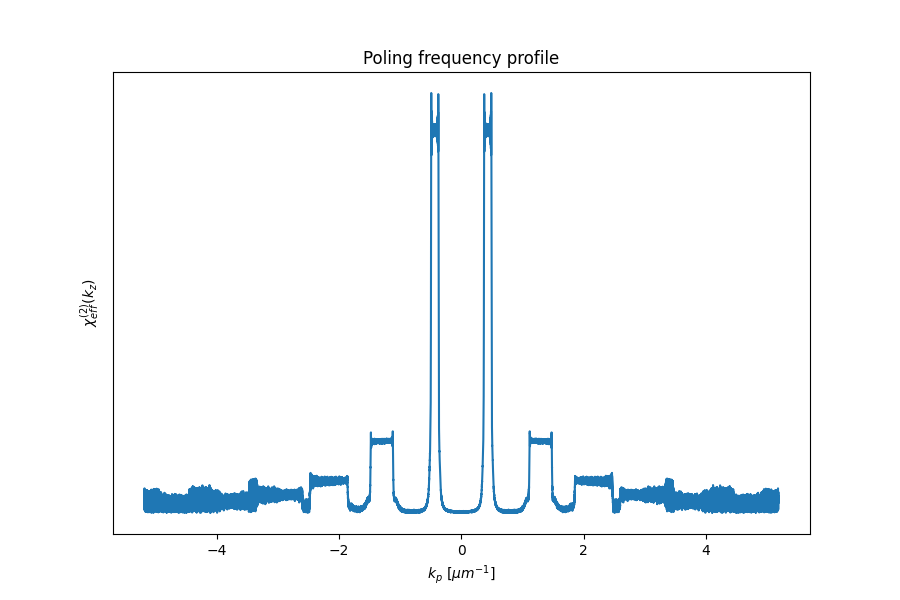

In [45]:
fig = plt.figure()
plt.plot(2 * np.pi / (1e6 * length2) *
         np.arange(-crystalAFC.poling.shape[0] / 2,
                    crystalAFC.poling.shape[0] / 2),
         np.abs(fftshift(fft(crystalAFC.poling))))
plt.yticks([])
plt.xlabel("$k_p ~ [\mu m^{-1}]$")
plt.ylabel("$\chi^{(2)}_{eff}(k_z)$")
plt.title("Poling frequency profile");

Pump undergoes SHG, SPM and XPM distortions

In [46]:
crystalAFC.setPump(afcPump)
crystalAFC.runPumpSimulation()

<IPython.core.display.Javascript object>


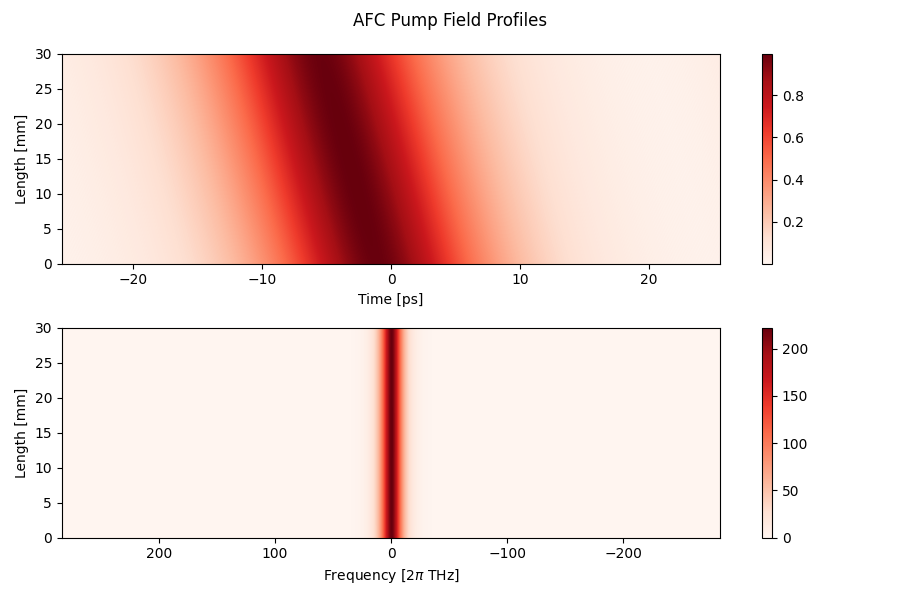

In [47]:
fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)
plt.imshow(np.abs(fftshift(crystalAFC.pumpTime[::100], axes=1)), cmap="Reds", aspect="auto", origin="lower",
           extent=[-tMax * timeScale, tMax * timeScale, 0, 1000 * length2])
plt.colorbar()
plt.xlabel("Time [ps]")
plt.ylabel("Length [mm]")

ax = fig.add_subplot(2, 1, 2)
plt.imshow(np.abs(fftshift(crystalAFC.pumpFreq[::100], axes=1)), cmap="Reds", aspect="auto", origin="lower",
           extent=[angFreqMax, -angFreqMax, 0, 1000 * length2])
plt.colorbar()
plt.xlabel("Frequency [$2 \pi$ THz]")
plt.ylabel("Length [mm]")

plt.suptitle("AFC Pump Field Profiles")

plt.tight_layout();

# Supermode Conversion
Instead of a full Green's function calculation, calculate the conversion of the primary supermodes

In [48]:
nConvert = 850
nLZpows = 8

inputSignals = fftshift(abases[-1][:nConvert], axes=1)

In [49]:
newSupermodes = np.zeros((nLZpows, nConvert, 2 * nt), np.complex128)

for i in range(nLZpows):
  crystalAFC.setPump(afcPump * ((i + 1) / nLZpows))
  crystalAFC.runPumpSimulation()
  newSupermodes[i] = (
    crystalAFC.batchSignalSimulation(inputSignals, inTimeDomain=False,
                                     nThreads=40, inputMode=1, runPump=False))

Conversion Efficiency per Supermode

<IPython.core.display.Javascript object>


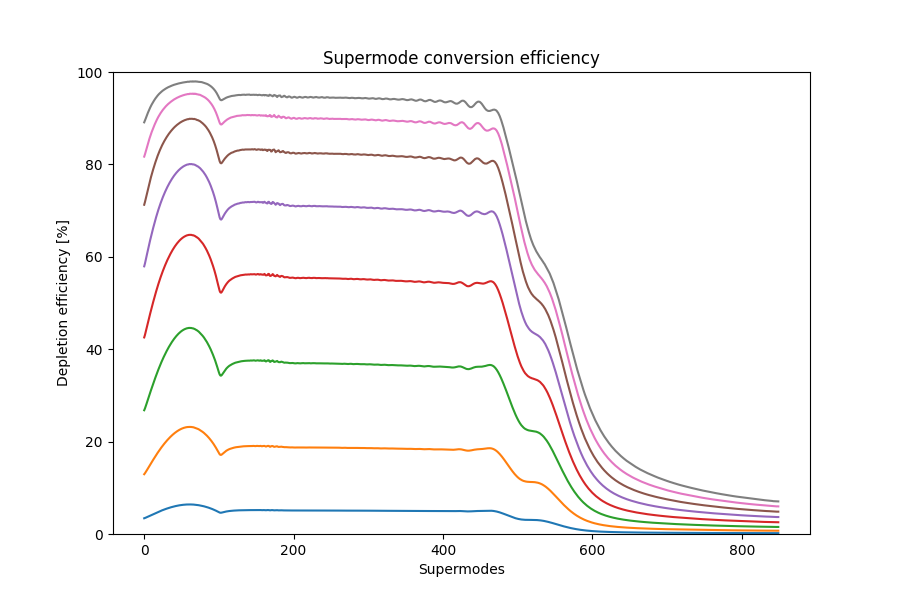

In [50]:
fig = plt.figure()
plt.plot(100 * (1 - np.sum(np.abs(newSupermodes[:, :, nt:])**2, axis=-1).T), "-")
# Equivalent to:
# plt.plot(100 *      np.sum(np.abs(newSupermodes[:, :, :nt])**2, axis=-1).T / amplitudeRatio, "--")

plt.ylim(0, 100)
plt.ylabel("Depletion efficiency [%]")
plt.xlabel("Supermodes")
plt.title("Supermode conversion efficiency");

New spectro-temporal supermodes

<IPython.core.display.Javascript object>


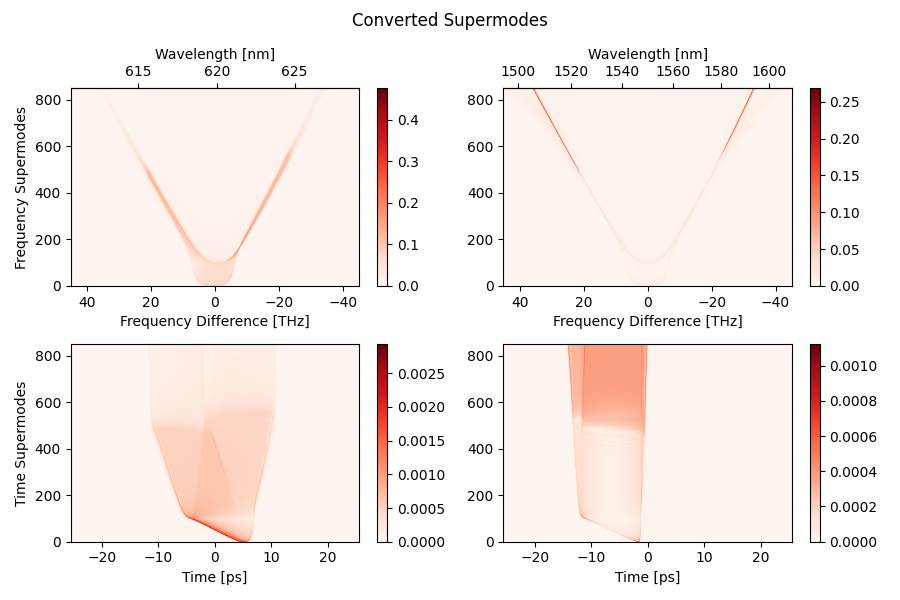

/usr/local/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/local/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in true_divide


In [51]:
fig = plt.figure()
plt.suptitle("Converted Supermodes")

ax = fig.add_subplot(2, 2, 1)
maxField = np.abs(newSupermodes[-1, :nConvert, :nt]).max()

plt.imshow(np.abs(fftshift(newSupermodes[-1, :nConvert, :nt], axes=1)),
           origin="lower", cmap="Reds", aspect="auto",
           extent=[angFreqMax / (2 * np.pi), -angFreqMax / (2 * np.pi), 0, nConvert],
          )
plt.ylabel("Frequency Supermodes")
plt.xlabel("Frequency Difference [THz]")
plt.colorbar()

fwd, bck = lambda x: 2e-3 * np.pi * c / (x + finalFreq),\
           lambda x: 2e-3 * np.pi * c / x - finalFreq
secax = ax.secondary_xaxis("top", functions=(fwd, bck))
secax.set_xlabel("Wavelength [nm]")


ax = fig.add_subplot(2, 2, 3)
maxField = np.abs(ifft(newSupermodes[-1, :nConvert, :nt])).max()

plt.imshow(np.abs(fftshift(ifft(newSupermodes[-1, :nConvert, :nt], axis=1), axes=1)),
           origin="lower", cmap="Reds", aspect="auto",
           extent=[-tMax * timeScale, tMax * timeScale, 0, nConvert],
          )
plt.ylabel("Time Supermodes")
plt.xlabel("Time [ps]")
plt.colorbar();


ax = fig.add_subplot(2, 2, 2)
maxField = np.abs(newSupermodes[-1, :nConvert, nt:]).max()

plt.imshow(np.abs(fftshift(newSupermodes[-1, :nConvert, nt:], axes=1)),
           origin="lower", cmap="Reds", aspect="auto",
           extent=[angFreqMax / (2 * np.pi), -angFreqMax / (2 * np.pi), 0, nConvert],
          )
plt.xlabel("Frequency Difference [THz]")
plt.colorbar()

fwd, bck = lambda x: 2e-3 * np.pi * c / (x + signalFreq),\
           lambda x: 2e-3 * np.pi * c / x - signalFreq
secax = ax.secondary_xaxis("top", functions=(fwd, bck))
secax.set_xlabel("Wavelength [nm]")

ax = fig.add_subplot(2, 2, 4)
maxField = np.abs(ifft(newSupermodes[-1, :nConvert,nt:])).max()

plt.imshow(np.abs(fftshift(ifft(newSupermodes[-1, :nConvert,nt:], axis=1), axes=1)),
           origin="lower", cmap="Reds", aspect="auto",
           extent=[-tMax * timeScale, tMax * timeScale, 0, nConvert],
          )
plt.xlabel("Time [ps]")
plt.colorbar()

plt.tight_layout();

Conversion Spectrum

In [52]:
convertedSpectrum = [fftshift(parametricFluorescence(newSupermodes[i, :, :nt], diags[-1][:nConvert]))
                     for i in range(nLZpows)]
convertedSpectrum = np.array(convertedSpectrum) * (1 / amplitudeRatio)

<IPython.core.display.Javascript object>


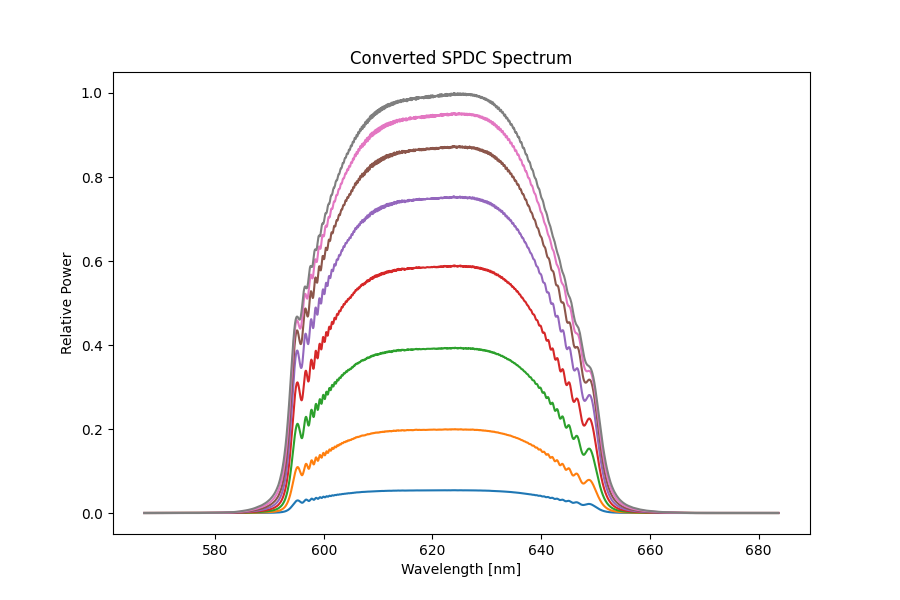

In [53]:
fig = plt.figure()
plt.plot(fftshift(wavelengthF), convertedSpectrum.T / np.max(convertedSpectrum))

plt.title("Converted SPDC Spectrum")
plt.xlabel("Wavelength [nm]")
plt.ylabel("Relative Power");

In [54]:
unconvertedSpectrum = fftshift(parametricFluorescence(inputSignals[:, :nt], diags[-1][:nConvert]))
unconvertedSpectrum = np.tile(unconvertedSpectrum, (nLZpows, 1))
unconvertedSpectrum -= convertedSpectrum

<IPython.core.display.Javascript object>


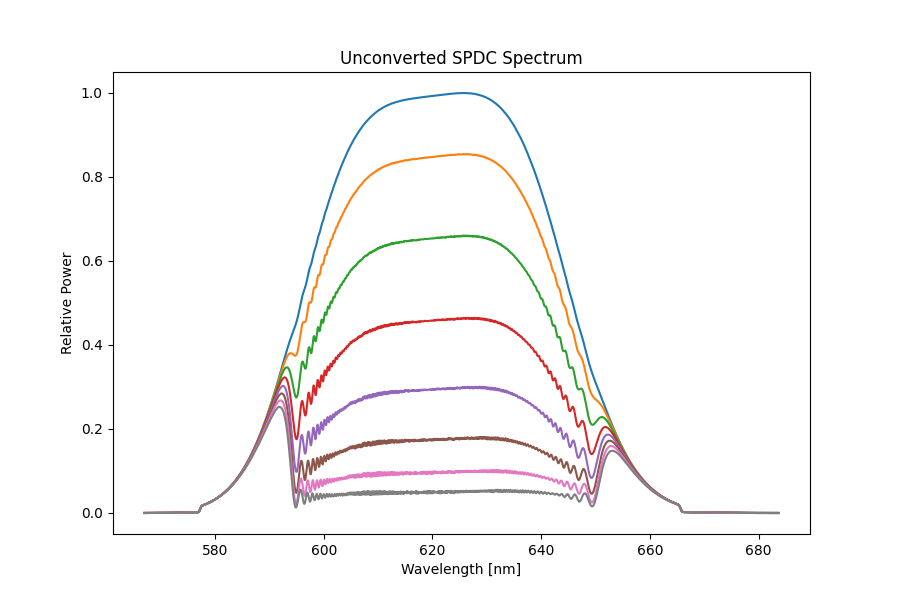

In [55]:
fig = plt.figure()
plt.plot(fftshift(wavelengthF), unconvertedSpectrum.T / np.max(unconvertedSpectrum))

plt.title("Unconverted SPDC Spectrum")
plt.xlabel("Wavelength [nm]")
plt.ylabel("Relative Power");

Saturation curve and fit

In [56]:
def lzFit(power, a, b, c):
  return a * (b - np.exp(-c * power))

totalEnergy = np.concatenate([[0], np.sum(convertedSpectrum, axis=1)])
pumpEnergy = np.square(np.arange(nLZpows+1) / nLZpows)

poptLZ, _ = curve_fit(lzFit, pumpEnergy, totalEnergy,
                      p0=[np.max(totalEnergy[:]), 1, 1])

print(poptLZ)

[624.93407009   1.00221406   3.31889282]


<IPython.core.display.Javascript object>


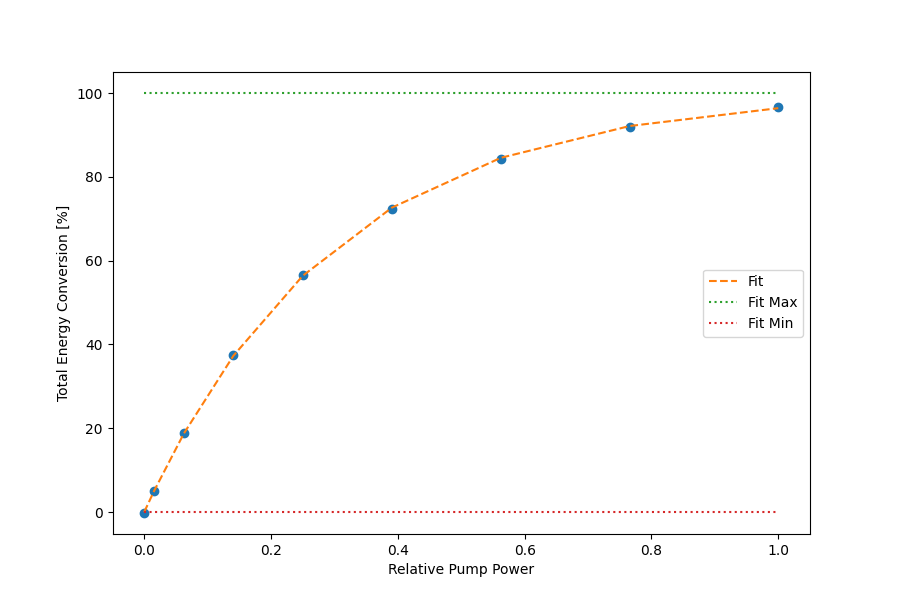

In [57]:
fig = plt.figure()

plt.plot(pumpEnergy, 100 * (totalEnergy / poptLZ[0] + (1 - poptLZ[1])), "o")
plt.plot(pumpEnergy, lzFit(pumpEnergy, 100, 1, poptLZ[-1]), "--", label="Fit")
plt.plot([pumpEnergy[0], pumpEnergy[-1]], [100, 100], ":", label="Fit Max")
plt.plot([pumpEnergy[0], pumpEnergy[-1]], [0, 0], ":", label="Fit Min")

plt.legend()
plt.xlabel("Relative Pump Power")
plt.ylabel("Total Energy Conversion [%]");

In [58]:
effSqueeze = np.block([[np.diag(diags[-1][:nConvert] + diags[-1][nt:nt+nConvert]),
                        np.diag(diags[-1][:nConvert] - diags[-1][nt:nt+nConvert])],
                       [np.diag(diags[-1][:nConvert] - diags[-1][nt:nt+nConvert]),
                        np.diag(diags[-1][:nConvert] + diags[-1][nt:nt+nConvert])]])

ds = 5 # downsample
mask = ((fftshift(wavelengthF) >= 590) & (fftshift(wavelengthF) <= 650))

In [59]:
effUnitary = np.block([[newSupermodes[-1].T, np.zeros_like(newSupermodes[-1].T)],
                       [np.zeros_like(newSupermodes[-1].T), newSupermodes[-1].T.conj()]])

effCov = effUnitary @ effSqueeze @ effUnitary.T.conj()
# Extract visible only part
convPhotonCov  = fftshift(effCov[2*nt:3*nt, 0:nt], axes=(0, 1))
convPhotonCov_ = fftshift(effCov[0*nt:1*nt, 0:nt], axes=(0, 1))
# Trace out parts outside of bandwidth
convPhotonCov  = convPhotonCov[np.ix_(mask, mask)]
convPhotonCov_ = convPhotonCov_[np.ix_(mask, mask)]
# Square for photon covariance
convPhotonCov = np.abs(convPhotonCov)**2 + np.abs(convPhotonCov_)**2
# Downsample
convPhotonCov = np.sum(convPhotonCov.reshape(convPhotonCov.shape[0]//ds, ds,
                                             convPhotonCov.shape[1]//ds, ds), axis=(1, 3))

<IPython.core.display.Javascript object>


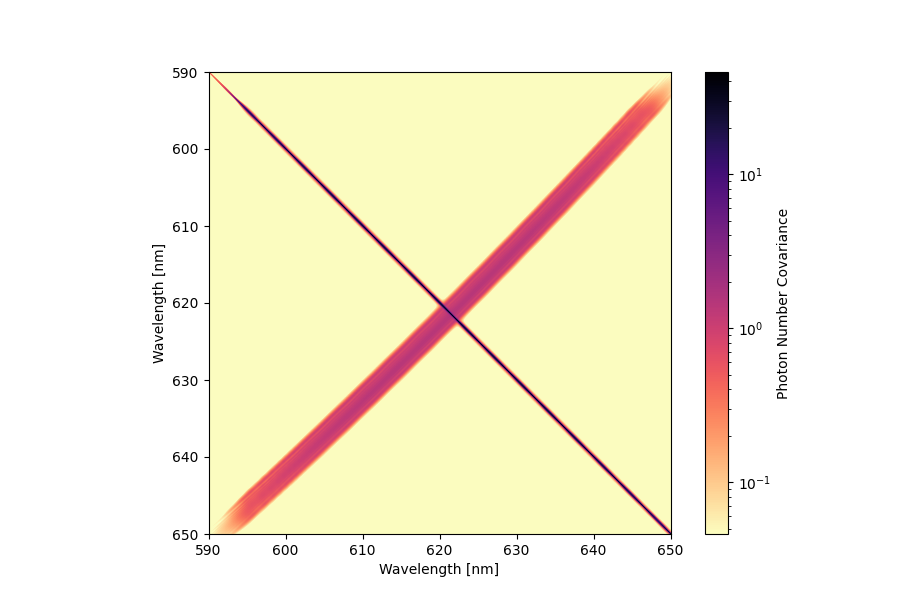

In [60]:
fig = plt.figure()
plt.imshow(convPhotonCov, cmap="magma_r", extent=[590, 650, 650, 590],
           norm=LogNorm(vmin=convPhotonCov.max() * 1e-3, vmax=convPhotonCov.max()))
plt.xlabel("Wavelength [nm]")
plt.ylabel("Wavelength [nm]")
plt.colorbar(label="Photon Number Covariance");